1-IMPORTANDO OS DADOS DOS MUNICIPIOS DE PARAÍBA DA API

In [1]:
#request é a biblioteca que permite o uso de APIs no Python
import requests as rq
link = "https://servicodados.ibge.gov.br/api/v1/localidades/estados/25/municipios"


In [2]:
#fazendo o dowload dos dados para um dataframe do Pandas
import pandas as pd
requisicao = rq.get(link)
if requisicao.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(requisicao.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


In [3]:
df_munic

,id,localidade
0,250010,Água Branca
1,250020,Aguiar
2,250030,Alagoa Grande
3,250040,Alagoa Nova
4,250050,Alagoinha
...,...,...
218,251690,Uiraúna
219,251700,Umbuzeiro
220,251710,Várzea
221,251720,Vieirópolis


A classificação será feita com base em 5 critérios:

- Serviços especializados (5 infos) 
- IDH
- Renda Per Capita 
- Taxa de alfabetização
- Taxa de desemprego

2- IMPORTANDO DADOS SERVIÇOS DE ATENDIMENTO

FONTE: MUNIC 2019

90201: 'Possui_delegacias_especializadas',

90358: 'Possui_legislacao_especifica_violencia_contra_a_mulher',

90626:'Possui_conferencias_sobre_direitos_ou_politicas_para_mulheres',

90640:'Possui_programas_direitos_humanos_protecao_mulheres_vitimas'

90397: Constituição de centros de referência e atendimento em direitos humanos

In [4]:
indicadores = ['90201','90358','90626','90640', '90397']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

#Adiciona os indicadores na url
for i, ind in enumerate(indicadores):
    if i != (len(indicadores)-1):
        url += ind + '|'
    else:
        url += ind + '/'

def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url

url = urlResultadosPorMunicipos(url, df_munic)

res = rq.request("GET", url)

#res.json()

In [5]:
ExcelentEquipaments = [90201, 90358] #Delegacias e legislação
GoodEquipaments = [90640] #proteção de mulheres vítimas 
okEquipaments = [90626,90397] #conferencias sobre direitos/politicas p mulheres e centros de referência atendimento em direitos humanos

if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        if indicador['id'] in ExcelentEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1*1.5 if x['2019']  == 'Sim' else 0)

        elif indicador['id'] in GoodEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1*1.0 if x['2019']  == 'Sim' else 0)

        else:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1*0.5 if x['2019']  == 'Sim' else 0)

        df_munic = pd.merge(df_munic, df_temp, on="id")

In [6]:
df_munic.describe()

,90201,90358,90397,90626,90640
count,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.067265,0.195067,0.006726,0.073991,0.538117
std,0.311137,0.505664,0.057732,0.177941,0.499667
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.500000,1.500000,0.500000,0.500000,1.000000


In [7]:
#Definie a quantidade de mecanismos de proteção e assistência da mulher 
#e agrega os dados ao dataframe principal.

df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90358] + df_munic[90397] + df_munic[90626] + df_munic[90640]

df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]
df_munic



,id,localidade,Rede_de_Protecao_assistencia
0,250010,Água Branca,0.0
1,250020,Aguiar,0.0
2,250030,Alagoa Grande,0.0
3,250040,Alagoa Nova,1.0
4,250050,Alagoinha,0.0
...,...,...,...
218,251690,Uiraúna,1.0
219,251700,Umbuzeiro,1.0
220,251710,Várzea,0.0
221,251720,Vieirópolis,0.0


3- IMPORTANDO IDH

In [8]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
x = res.json()

df_temp = pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)

df_temp = df_temp[['id', 'IDH']]

df_munic = pd.merge(df_munic, df_temp, on='id')

4-IMPORTANDO PIB

In [9]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)     

res = rq.request("GET", url)

df_temp = pd.json_normalize(res.json()[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

5- IMPORTANDO TAXA DE ALFABETIZAÇÃO

In [10]:
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/1383/periodos/-6/variaveis/1646?localidades=N6[N3[25]]|N2[1]&classificacao=2[6794]'

res = rq.request("GET", url)
info = res.json()


df_temp = pd.json_normalize(info[0]['resultados'][0]['series'])

df_temp.rename(columns={'localidade.id': 'id', 'serie.2010': 'Alfabetizacao'}, inplace=True)
df_temp = df_temp[['id', 'Alfabetizacao']]

for index, row in df_temp.iterrows():
    if len(row['id']) == 7:
        df_temp.at[index, 'id'] = row['id'][:-1]  # Remove o último caractere

df_munic = pd.merge(df_munic, df_temp, on='id')



6-IMPORTANDO TAXA DE DESEMPREGO

In [11]:
df = pd.read_csv('/work/ibge_censo_cnv_desem114957200_239_72_1 (1).csv', sep=";")
df.rename(columns={'Municipio': 'id', 'Taxa_de_desemprego_16a_e+': 'Desemprego'}, inplace=True)
limite_caracteres = 6
df['id'] = df['id'].str.slice(0, limite_caracteres)
df_munic = pd.merge(df_munic, df, on='id')
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,Alfabetizacao,Desemprego
0,250010,Água Branca,0.0,0.572,8065.69,76.8,"4,34"
1,250020,Aguiar,0.0,0.597,8890.32,65.4,"4,24"
2,250030,Alagoa Grande,0.0,0.582,9688.00,68.4,"9,62"
3,250040,Alagoa Nova,1.0,0.576,15626.16,74.2,"6,67"
4,250050,Alagoinha,0.0,0.595,7924.48,68.2,"6,52"
...,...,...,...,...,...,...,...
218,251690,Uiraúna,1.0,0.636,11403.85,75.2,"6,16"
219,251700,Umbuzeiro,1.0,0.584,7728.58,68.4,"3,95"
220,251710,Várzea,0.0,0.707,11202.52,87.7,"5,76"
221,251720,Vieirópolis,0.0,0.571,7819.50,65.1,"9,19"


<img src="image-20230921-133716.png" width="" align="" />

TRANSFORMANDO COLUNAS EM TIPOS NUMÉRICOS

In [12]:
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['Alfabetizacao'] = pd.to_numeric(df_munic['Alfabetizacao'])
df_munic['Desemprego'] = df['Desemprego'].str.replace(',', '.').astype(float)

In [13]:
df_munic.describe()

,Rede_de_Protecao_assistencia,IDH,PIB,Alfabetizacao,Desemprego
count,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.881166,0.587655,10953.086951,73.033632,7.007668
std,0.980901,0.037823,6986.385833,5.618477,3.369080
min,0.000000,0.513000,6726.470000,60.900000,0.800000
25%,0.000000,0.565000,8510.865000,69.100000,4.700000
50%,1.000000,0.583000,9621.100000,72.600000,6.510000
75%,1.000000,0.608000,10905.660000,76.650000,8.640000
max,4.500000,0.763000,96359.300000,92.400000,21.230000


7- VISUALIZAÇÃO E NORMALIZAÇÃO DOS DADOS

In [15]:
#Renomeando a coluna IAP
df_munic.rename(columns = {'Rede_de_Protecao_assistencia':'IAP'}, inplace=True)

In [16]:
#Invertendo os valores da coluna desemprego
df_munic['Desemprego'] = df_munic.iloc[:,6:7].apply(lambda x: -x.abs(), axis=1)

In [17]:
df_munic

,id,localidade,IAP,IDH,PIB,Alfabetizacao,Desemprego
0,250010,Água Branca,0.0,0.572,8065.69,76.8,-4.34
1,250020,Aguiar,0.0,0.597,8890.32,65.4,-4.24
2,250030,Alagoa Grande,0.0,0.582,9688.00,68.4,-9.62
3,250040,Alagoa Nova,1.0,0.576,15626.16,74.2,-6.67
4,250050,Alagoinha,0.0,0.595,7924.48,68.2,-6.52
...,...,...,...,...,...,...,...
218,251690,Uiraúna,1.0,0.636,11403.85,75.2,-6.16
219,251700,Umbuzeiro,1.0,0.584,7728.58,68.4,-3.95
220,251710,Várzea,0.0,0.707,11202.52,87.7,-5.76
221,251720,Vieirópolis,0.0,0.571,7819.50,65.1,-9.19


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

p1 = df_munic.iloc[:,2:3] #IAP
p2 = df_munic.iloc[:,3:4] #IDH
p3 = df_munic.iloc[:,4:5] #PIB
p4 = df_munic.iloc[:,5:6] #Alfabetizaçao
p5 = df_munic.iloc[:,6:7] #Desemprego

Histograma e boxplot IAP

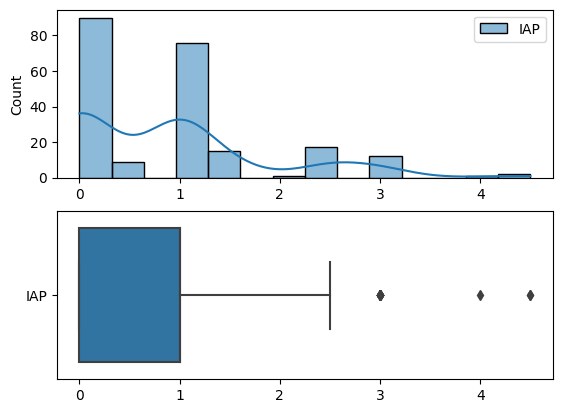

In [19]:
fig, (ax1, ax2) = plt.subplots(2)
# histograma e boxplot IAP
sns.histplot(p1, kde=True, ax=ax1)
sns.boxplot(p1, orient="h", ax=ax2)

plt.show()

Histograma e boxplot da coluna IDH

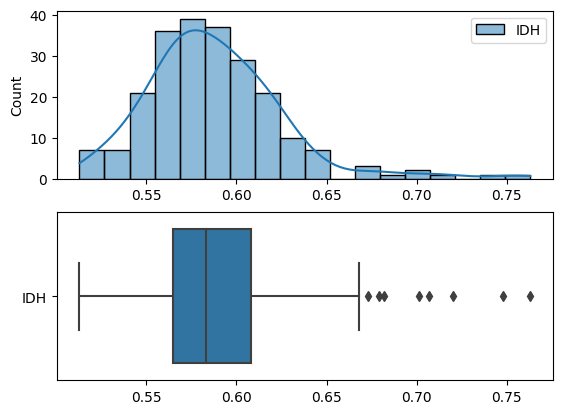

In [20]:
fig, (ax3, ax4) = plt.subplots(2)
# histograma e boxplot IDH
sns.histplot(p2, kde=True, ax=ax3)
sns.boxplot(p2, orient="h", ax=ax4)

plt.show()

Histograma e boxplot da coluna PIB

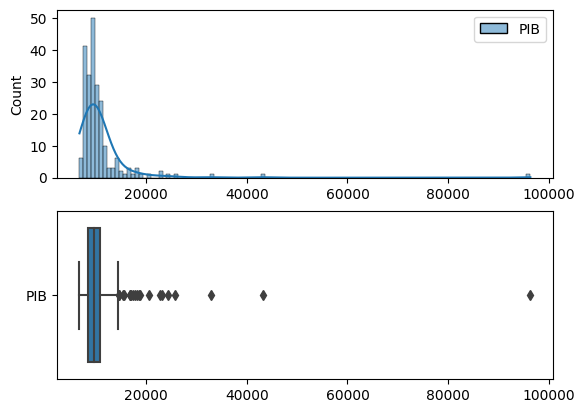

In [21]:
fig, (ax5, ax6) = plt.subplots(2)
# histograma e boxplot PIB
sns.histplot(p3, kde=True, ax=ax5)
sns.boxplot(p3, orient="h", ax=ax6)

plt.show()

Histograma e boxplot da coluna Alfabetização

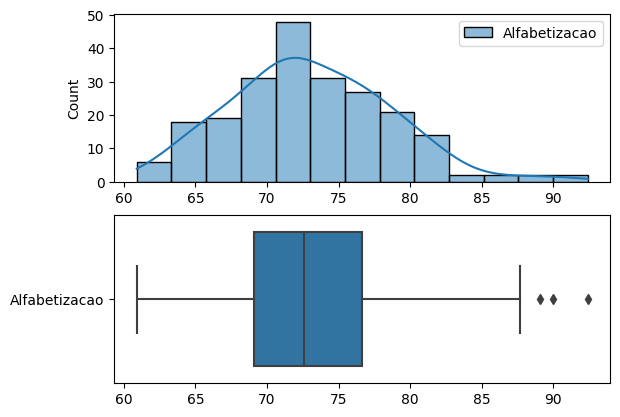

In [22]:
fig, (ax7, ax8) = plt.subplots(2)
# histograma e boxplot alfabetização
sns.histplot(p4, kde=True, ax=ax7)
sns.boxplot(p4, orient="h", ax=ax8)

plt.show()

Histograma e boxplot da coluna Desemprego

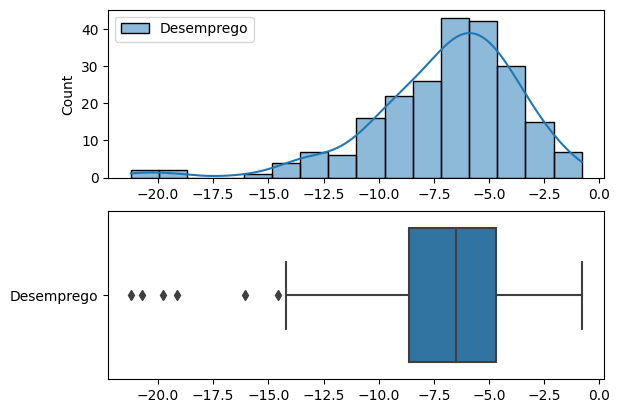

In [23]:
fig, (ax9, ax10) = plt.subplots(2)
# histograma e boxplot Desemprego
sns.histplot(p5, kde=True, ax=ax9)
sns.boxplot(p5, orient="h", ax=ax10)

plt.show()

In [24]:
#Vizualizando valores nulos
df_munic.isnull().sum()

id               0
localidade       0
IAP              0
IDH              0
PIB              0
Alfabetizacao    0
Desemprego       0
dtype: int64

8- Normalização

In [25]:
#usando o min max scaler para  para dimensionar os atributos
# do conjunto de dados para um intervalo específico (entre -1 e 1) 
from sklearn.preprocessing import MinMaxScaler

# Lista das colunas que você deseja escalar
columns_to_scale = df_munic.iloc[:,2:7]
# Crie uma instância do MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

for i in columns_to_scale:
    df_munic[i] = scaler.fit_transform(df_munic[[i]])

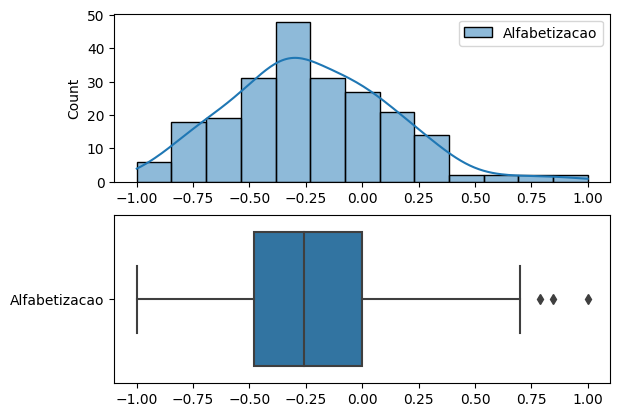

In [26]:
#visualizando os dados da coluna Desemprego após a mudança de escala
p12 = df_munic.iloc[:,5:6] #Desemprego

fig, (ax10, ax11) = plt.subplots(2)
# histograma e boxplot Desemprego
sns.histplot(p12, kde=True, ax=ax10)
sns.boxplot(p12, orient="h", ax=ax11)

plt.show()

In [27]:
df_munic.describe()

,IAP,IDH,PIB,Alfabetizacao,Desemprego
count,223.000000,223.000000,223.000000,223.000000,223.000000
mean,-0.608371,-0.402762,-0.905690,-0.229611,0.392299
std,0.435956,0.302580,0.155889,0.356729,0.329817
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.584000,-0.960184,-0.479365,0.232501
50%,-0.555556,-0.440000,-0.935411,-0.257143,0.441018
75%,-0.555556,-0.240000,-0.906749,0.000000,0.618209
max,1.000000,1.000000,1.000000,1.000000,1.000000


Definindo os limiares a partir dos quartis

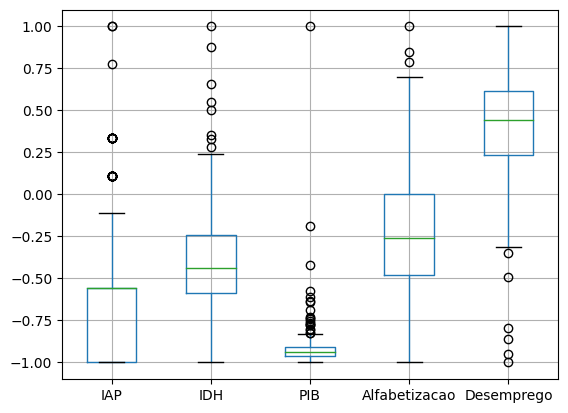

array([[-1.        , -0.584     , -0.96018434, -0.47936508,  0.23250122],
       [-0.55555556, -0.44      , -0.93541139, -0.25714286,  0.44101811],
       [-0.55555556, -0.24      , -0.90674868,  0.        ,  0.61820852]])

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")
    
    
def print_limits(dataset) -> np.array:

    res = np.zeros((3, 5))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    plt.show()

    #print(f"caps: {caps}")
    #print(f"outliers: {outliers}")
    #print(f"boxes: {boxes}")
    #print(f"medians: {medians}")
    #print(f"whiskers: {whiskers}")


    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]


        # res[0][cont] = lower_range
        # res[1][cont] = Q1
        # res[2][cont] = M
        # res[3][cont] = Q3
        # res[4][cont] = upper_range

        # res[0][cont] = Q1
        # res[1][cont] = M
        # res[2][cont] = Q3
        # res[3][cont] = upper_range

        res[0][cont] = Q1
        res[1][cont] = M
        res[2][cont] = Q3


        cont += 1
    
    
    return res
         

#print_limits(df_munic.iloc[:,2:7])

6- APLICAÇÃO DO ELECTRE Tri-b

In [29]:
!pip install pyDecision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 19.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


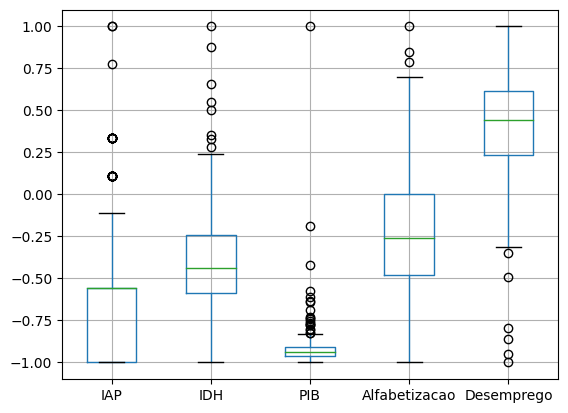

array([[-1.        , -0.584     , -0.96018434, -0.47936508,  0.23250122],
       [-0.55555556, -0.44      , -0.93541139, -0.25714286,  0.44101811],
       [-0.55555556, -0.24      , -0.90674868,  0.        ,  0.61820852]])

In [30]:
Q = [0.2,      0.2,       0.2,     0.2,     0.2]
P = [0.4,      0.4,       0.4,     0.4,     0.4]
V = [1.0,      1.0,       1.0,     1.0,     1.0]
W = [44.4,    16.5,      6.3,    16.5,    16.5]
B = print_limits(df_munic.iloc[:,2:7]).tolist()

np.array(B)

In [31]:
import matplotlib.patches as mpatches

from sklearn.decomposition import TruncatedSVD


def plot_points(data, classification):
    plt.style.use('ggplot')
    #colors = {'A':'#54FF00', 'B':'#FFEB00', 'C':'#FF9500', 'D':'#FF0000', 'E':'#FF0000', 'F':'#ff796c', 'G':'#04d8b2', 'H':'#ffb07c', 'I':'#aaa662', 'J':'#0485d1', 'K':'#fffe7a', 'L':'#b0dd16', 'M':'#85679', 'N':'#12e193', 'O':'#82cafc', 'P':'#ac9362', 'Q':'#f8481c', 'R':'#c292a1', 'S':'#c0fa8b', 'T':'#ca7b80', 'U':'#f4d054', 'V':'#fbdd7e', 'W':'#ffff7e', 'X':'#cd7584', 'Y':'#f9bc08', 'Z':'#c7c10c'}
    colors = {'A':'#FFFFCC', 'B':'#FEBF5A', 'C':'#F43D25', 'D':'#800026'}
    classification_ = copy.deepcopy(classification)
    color_leg = {}
    if (data.shape[1] == 2):
        data_proj = np.copy(data)
    else:
        tSVD      = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
        tSVD_proj = tSVD.fit_transform(data)
        data_proj = np.copy(tSVD_proj)
        #variance  = sum(np.var(tSVD_proj, axis = 0) / np.var(tSVD_proj, axis = 0).sum())
    class_list  = list(set(classification_))
    for i in range(0, len(classification_)):
        classification_[i] = str(classification_[i])
    for i in range(0, len(classification_)):
        for j in range(0, len(class_list)):
            classification_[i] = classification_[i].replace(str(class_list[j]), str(chr(ord('A') + class_list[j])))
    class_list = list(set(classification_))
    class_list.sort() 
    for i in range(0, len(class_list)):
        color_leg[class_list[i]] = colors[class_list[i]]
    patchList = []
    for key in color_leg:
        data_key = mpatches.Patch(color = color_leg[key], label = key)
        patchList.append(data_key)
    for i in range(0, data_proj.shape[0]):
        plt.text(data_proj[i, 0], data_proj[i, 1], 'x' + str(i+1), size = 10, ha = 'center', va = 'center', bbox = dict(boxstyle = 'round', ec = (0.0, 0.0, 0.0), fc = colors[classification_[i]],))
    plt.gca().legend(handles = patchList, loc = 'center left', bbox_to_anchor = (1.05, 0.5))
    axes = plt.gca()
    xmin = np.amin(data_proj[:,0])
    xmax = np.amax(data_proj[:,0])
    #axes.set_xlim([xmin*0.7, xmax*1])
    axes.set_xlim([xmin, xmax*1])
    ymin = np.amin(data_proj[:,1])
    ymax = np.amax(data_proj[:,1])
    if (ymin < ymax):
        axes.set_ylim([ymin, ymax])
    else:
        axes.set_ylim([ymin*0.7, ymax*1])
    plt.show()

In [32]:
import copy
from pyDecision.algorithm import electre_tri_b

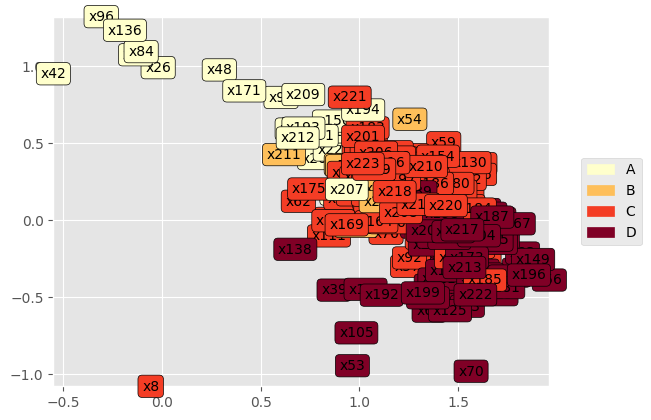

In [33]:
classification = electre_tri_b(np.array(df_munic.iloc[:, 2:7]), W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'pc', graph = False)

plot_points(np.array(df_munic.iloc[:, 2:7]), classification)

In [34]:
df_munic['CLASS'] = classification

In [35]:
df_munic['CLASS'].value_counts()

2    104
3     83
0     25
1     11
Name: CLASS, dtype: int64

In [36]:
df_munic.query('CLASS == 3')

,id,localidade,IAP,IDH,PIB,Alfabetizacao,Desemprego,CLASS
1,250020,Aguiar,-1.0,-0.328,-0.951717,-0.714286,0.663240,3
2,250030,Alagoa Grande,-1.0,-0.448,-0.933919,-0.523810,0.136564,3
4,250050,Alagoinha,-1.0,-0.344,-0.973268,-0.536508,0.440039,3
5,250053,Alcantil,-1.0,-0.480,-0.972289,-0.282540,0.765051,3
6,250057,Algodão de Jandaíra,-1.0,-0.720,-0.916600,-0.384127,0.396965,3
...,...,...,...,...,...,...,...,...
203,251580,Serra Redonda,-1.0,-0.544,-0.945633,-0.352381,0.558492,3
212,251640,Tacima,-1.0,-0.696,-0.986983,-0.288889,0.117964,3
213,251650,Taperoá,-1.0,-0.480,-0.977236,-0.142857,0.297112,3
216,251675,Tenório,-1.0,-0.456,-0.934981,-0.257143,0.478218,3


11- GEOPANDAS

In [37]:
!pip install geopandas


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [38]:
import geopandas as gpd

gdf_munic = gpd.read_file('/work/geojs-25-mun.json')

#gdf_munic.head()
for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(df_munic, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

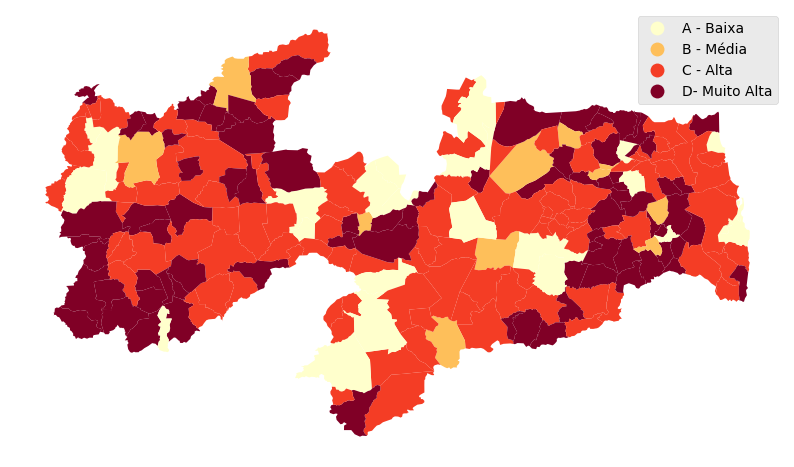

In [39]:
clusdict={3: 'D- Muito Alta', 2: 'C - Alta', 1: 'B - Média', 0: 'A - Baixa' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='YlOrRd')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b64a2edc-c602-4f9f-8ed1-94b978dae677' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>